# Orbital precession

In this example notebook, we want to study elliptic orbits for ``time-like`` particles around a black hole in PyGRO, to show the capabilities of the code to reproduce the results of the orbital precession and also go beyond the usual firs't order formulas.

Let's start by importing the necessary modules:

In [1]:
import pygro
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.interpolate import interp1d
from scipy.optimize import fsolve

In [2]:
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['text.usetex'] = False
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = "#cdcdcd"
mpl.rcParams['grid.linestyle'] = ":"
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#767afe", "#2b926c", "#b53546", "#e78b50", "#703676", "#b68ec4", "#37b4b4", "#c8c330"]) 
mpl.rcParams['font.family'] = 'cmr10'
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['axes.unicode_minus']=False

defining the usual Schwarzschild metric:

In [3]:
name = "Schwarzschild spacetime"
coordinates = ["t", "r", "theta", "phi"]

transform_functions = [
    "t",
    "r*sin(theta)*cos(phi)",
    "r*sin(theta)*sin(phi)",
    "r*cos(theta)"
]

line_element = "-(1-2*M/r)*dt**2+1/(1-2*M/r)*dr**2+r**2*(dtheta**2+sin(theta)**2*dphi**2)"

metric = pygro.Metric(
    name = name,
    coordinates = coordinates,
    line_element = line_element,
    transform = transform_functions,
    M = 1,
)


(PyGRO) INFO: Initializing Schwarzschild spacetime.
(PyGRO) INFO: Calculating inverse metric.
(PyGRO) INFO: Calculating symbolic equations of motion.
(PyGRO) INFO: Computing helper functions to normalize 4-velocity.
(PyGRO) INFO: The Metric (Schwarzschild spacetime) has been initialized.


and defining the ``GeodesicEngine`` with a stopping criterion at the event horizon:

In [4]:
geo_engine = pygro.GeodesicEngine(metric)
geo_engine.set_stopping_criterion("r > 2.00001*M", "horizon")

(PyGRO) INFO: Linking Schwarzschild spacetime to the Geodesic Engine
(PyGRO) INFO: Metric linking complete.


Let us now initialize an ``Orbit`` object with a high eccentricity of 0.8 and a semi-major axis of $a = 1000M$. We will not assign values to the angular orbital parameters which will be automatically be fixed to $0^\circ$.

In [5]:
orbit = pygro.Orbit(geo_engine)
orbit.set_orbital_parameters(t_P = 0, a = 1000, e = 0.8)

(PyGRO) WARNING: Longitude of ascending node not specified, set to 0.
(PyGRO) WARNING: Argument of the pericenter not specified, set to 0.
(PyGRO) WARNING: Inclination not specified, set to 0.


We can use the Newtonian formula for the orbital period as an estimator of how many turns we want our orbit to make around the black hole.

In [6]:
T = np.sqrt(4*np.pi**2*orbit.a**3)

print(f"Keplerian period = {T:.0f} M")

Keplerian period = 198692 M


For example, let's integrate the orbit over five orbital periods:

In [7]:
orbit.integrate(T*5, 0.1, accuracy_goal = 15, precision_goal = 15, verbose=True)

(PyGRO) INFO: Starting integration.
(PyGRO) INFO: Integration completed in 0.39807 s with result 'done'.


and visualize the results

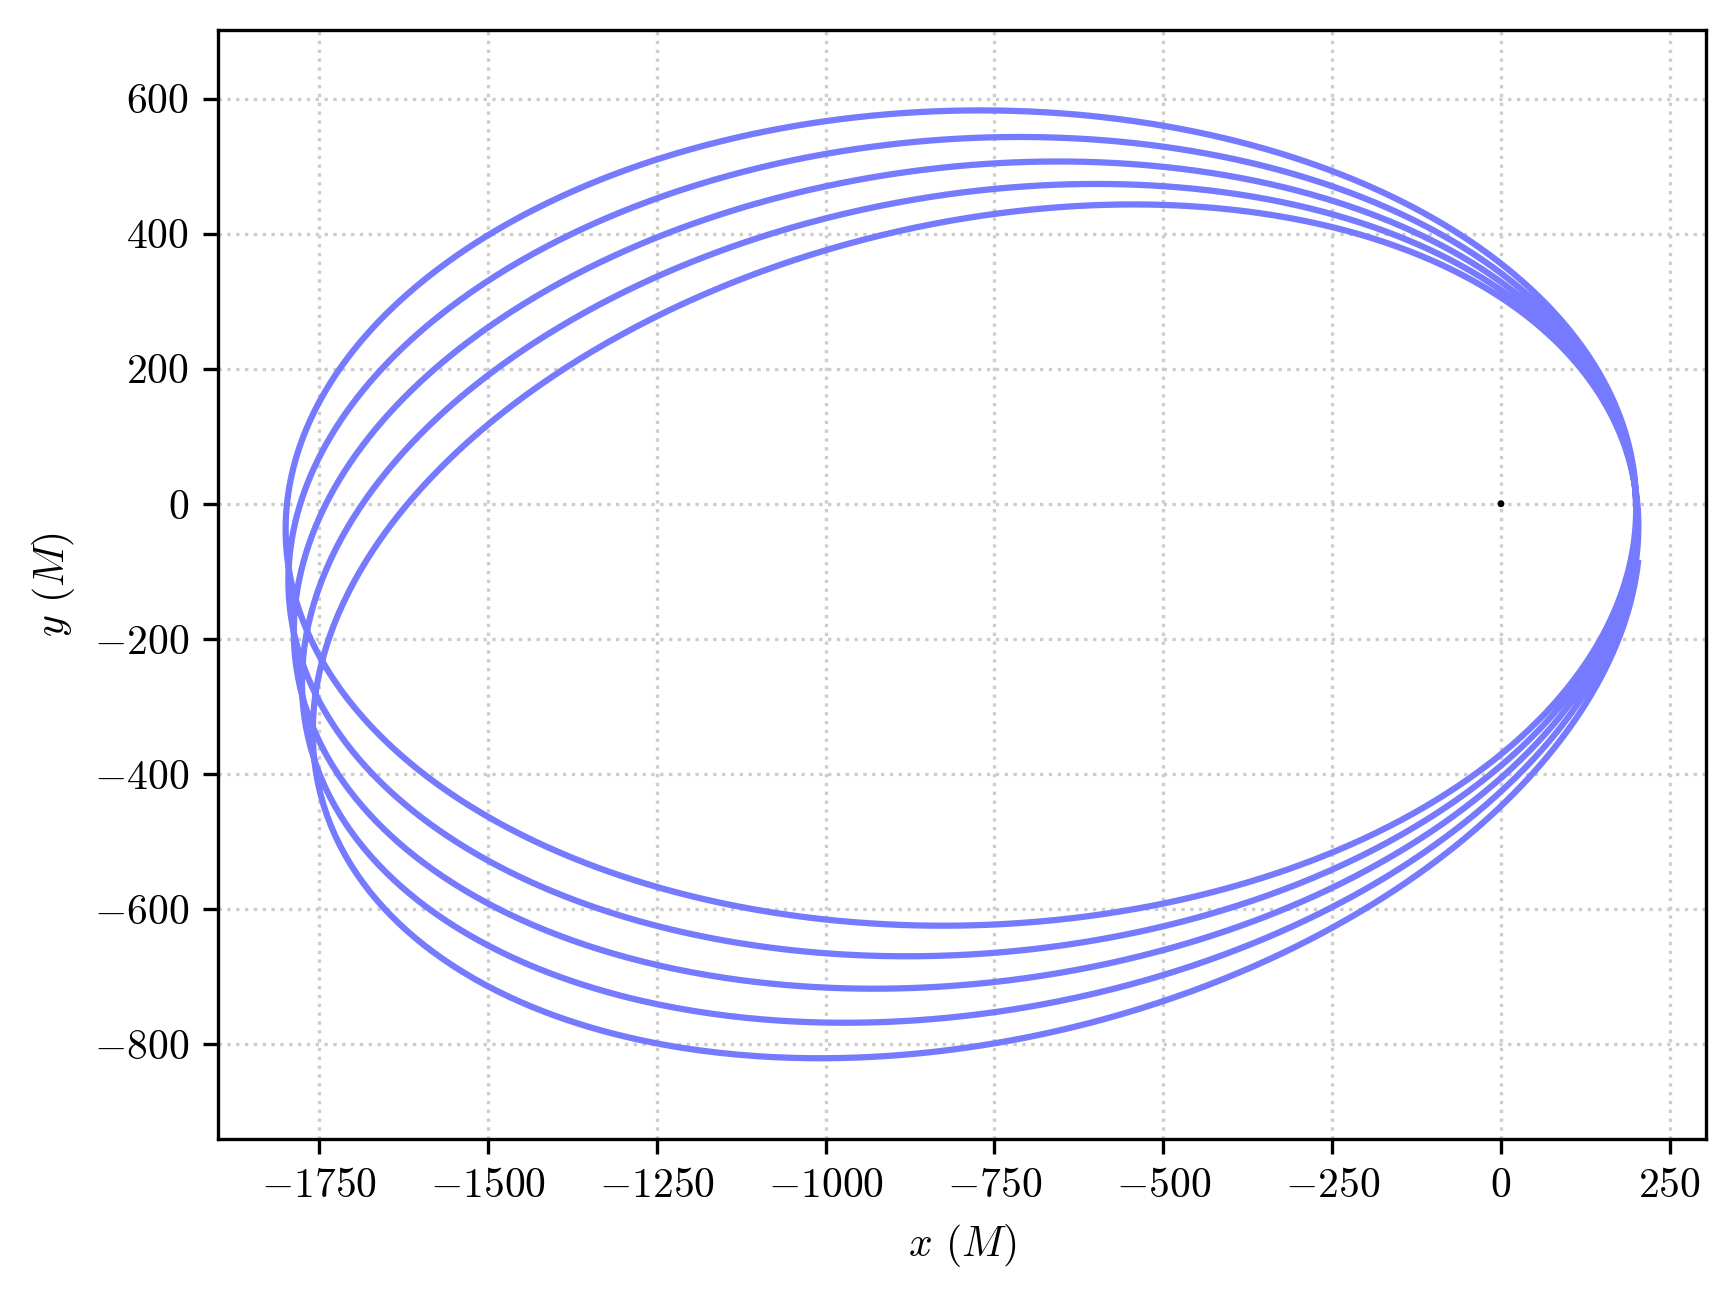

In [8]:
plt.close('all')

fig, ax = plt.subplots()

t, x, y, z = metric.transform(orbit.geo.x.T)

ax.plot(x, y)

theta = np.linspace(0, 2*np.pi, 150)
x_bh = 2*np.cos(theta)
y_bh = 2*np.sin(theta)

ax.fill(x_bh, y_bh, color = "k")

ax.set_axisbelow(True)

ax.axis('equal')

ax.set_xlabel(r'$x$ ($M$)')
ax.set_ylabel(r'$y$ ($M$)')

plt.show()

We've got a nicely precessing orbit!

To see what is the impact of the choice of the orbital parameters in PyGRO, let's plot the radial coordinate of the geodesic as a function of coordinate time

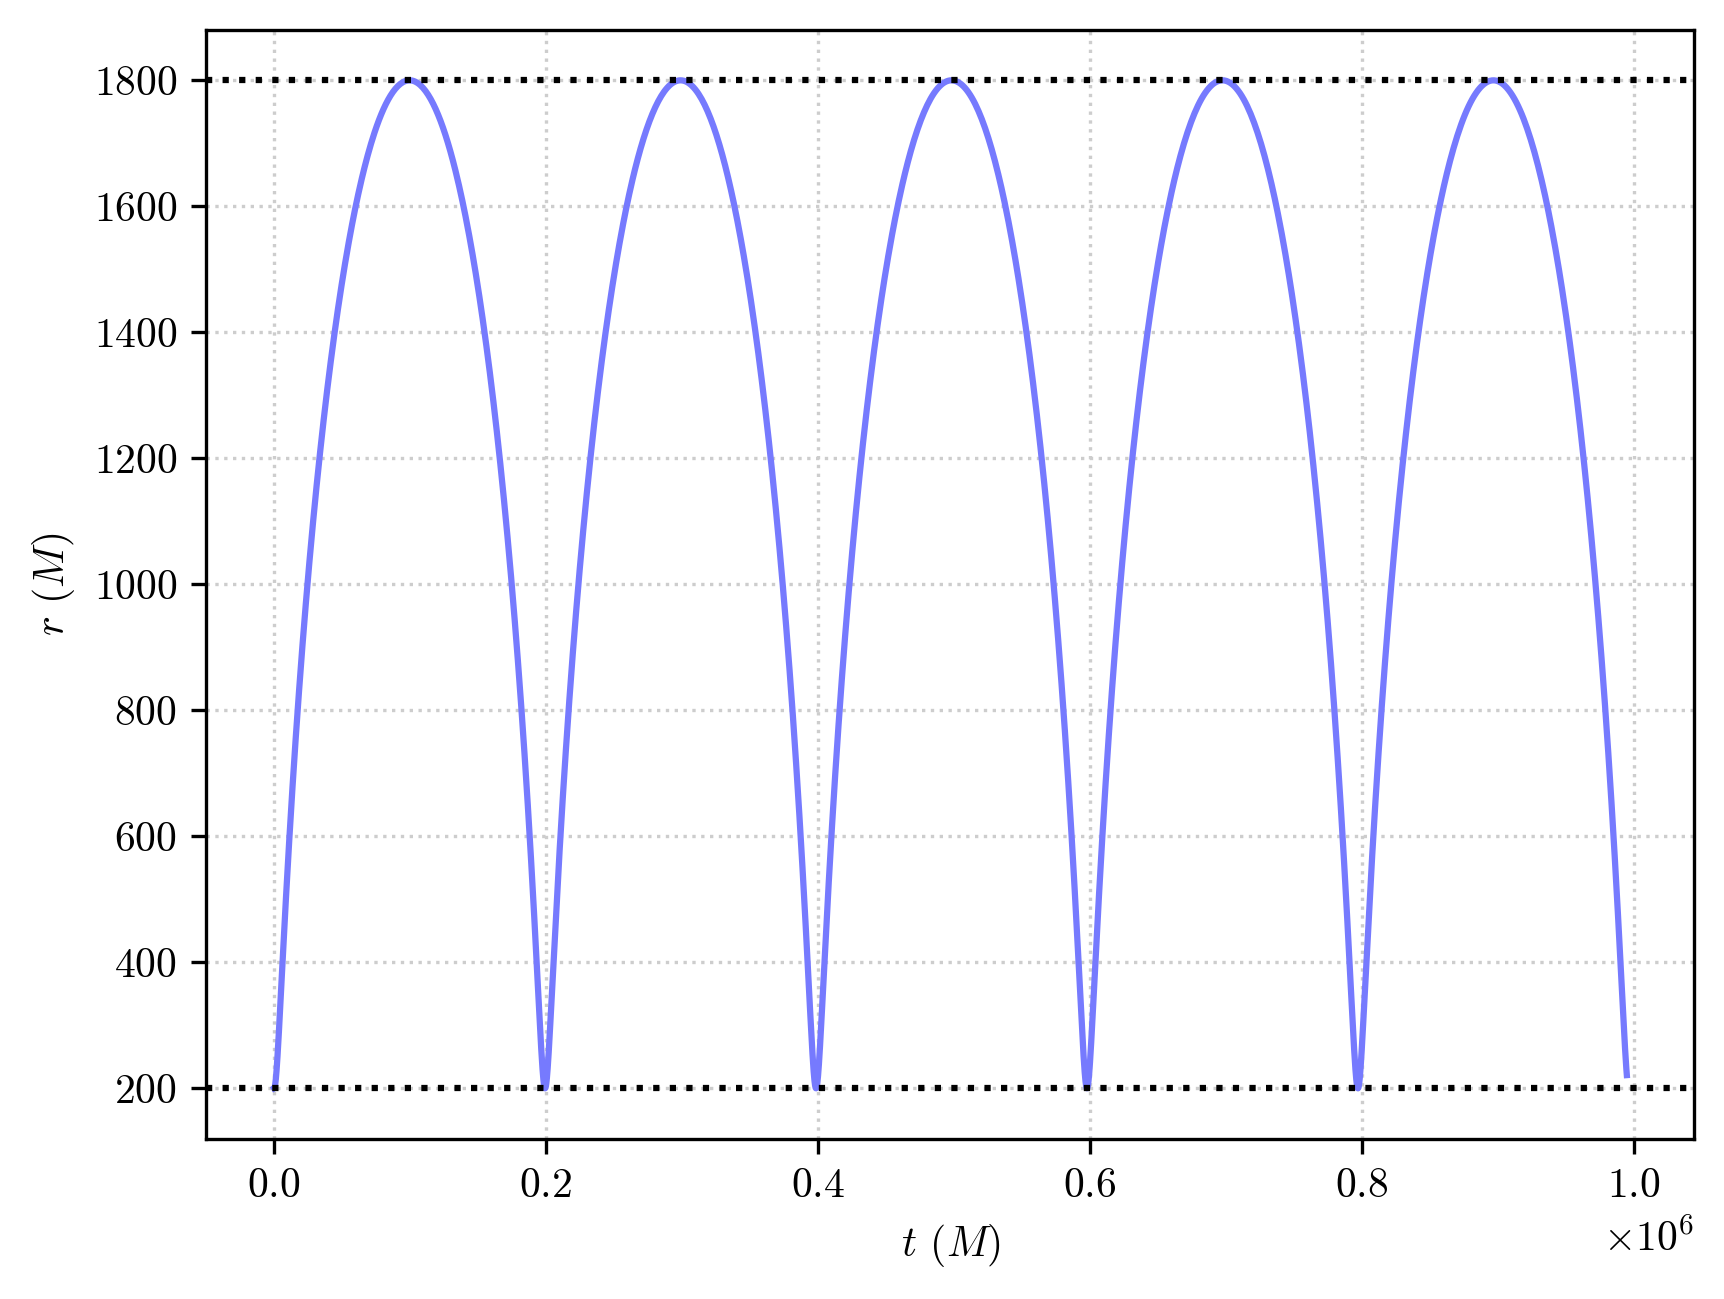

In [9]:
plt.close('all')

fig, ax = plt.subplots()

ax.plot(orbit.geo.x[:,0], orbit.geo.x[:,1])

ax.axhline(orbit.a*(1-orbit.e), linestyle = ":", color = "k")
ax.axhline(orbit.a*(1+orbit.e), linestyle = ":", color = "k")

ax.set_xlabel(r"$t$ ($M$)")
ax.set_ylabel(r"$r$ ($M$)")

plt.show()

We have obtained exactly what we have asked for. The orbit of a time-like geodesic with $a = 1000M$ and $e = 0.8$ (whose radial coordiante thus periodically oscillates between the pericenter at $r_p = a(1-e) = 200M$ and the apocenter $r_a = a(1+e) = 1800M$) integrated over 5 orbital periods, starting at the pericenter.

PyGRO autonomously fixed the initial spacetime coordinates of the orbit and the components of the 4-velocity to obtain this.

Moreover, the orbit is not a closed ellipse as in Newtonian gravity, but it precedes on the equatorial plane, which is one of the most peculiar predicitons of General Relativity and one of its classical tests. 

To quantifiy this orbital precession, let's look at the derivative of the radial coordianate, $\dot{r}$, as a function of the azimuthal angle, $\phi$:

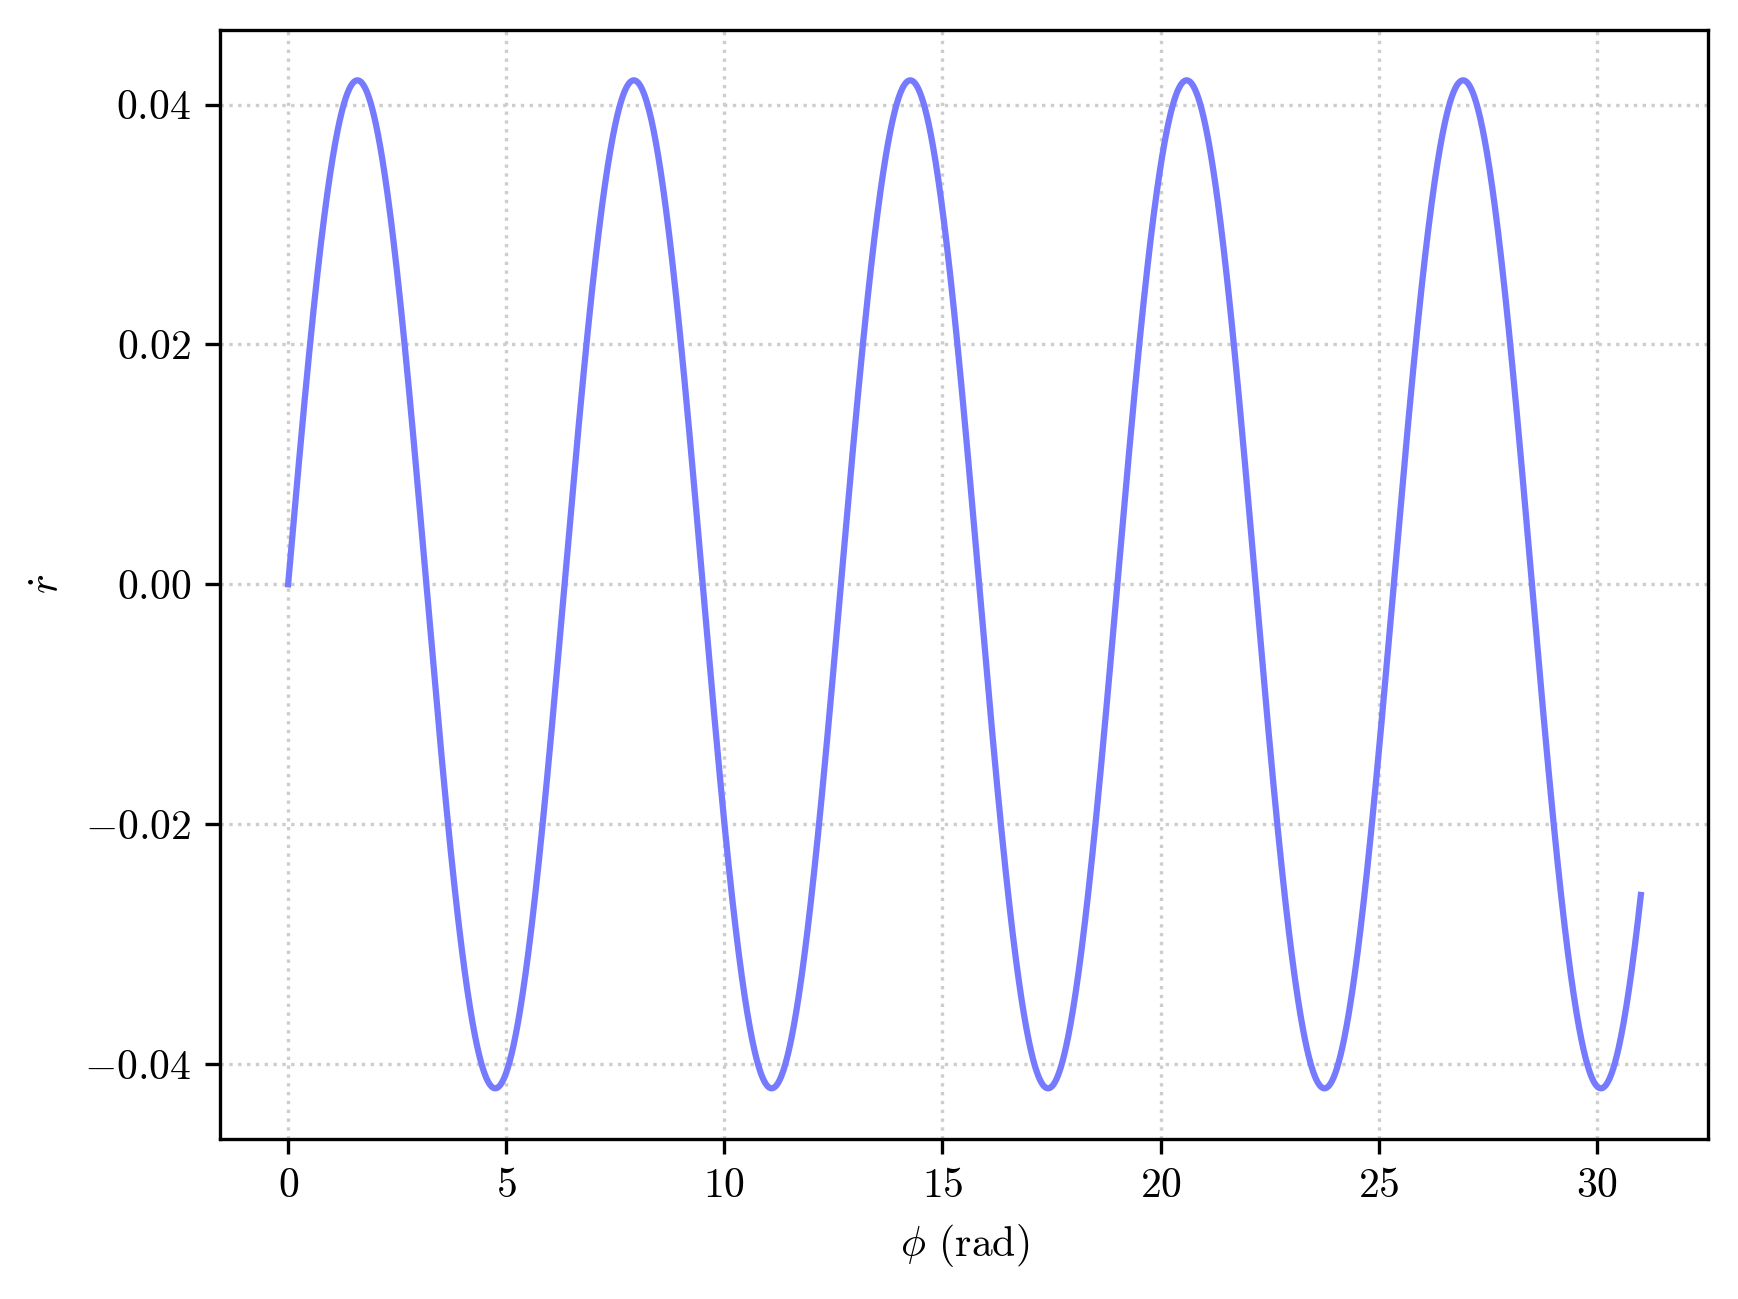

In [10]:
fig, ax = plt.subplots()

ax.plot(orbit.geo.x[:,3], orbit.geo.u[:,1])

ax.set_xlabel(r"$\phi$ (rad)")
ax.set_ylabel(r"$\dot{r}$")

plt.show()

Starting at pericenter, the initial azimuthal angle is $\phi=0$ and the this corresponds to a radial turning point, *i.e.* $\dot{r}=0$.

If the orbit didn't precess it would complete a turn ($\phi = 2\pi) and be back at a radial turning point. However if we zoom in the previous plout at around $2\pi$

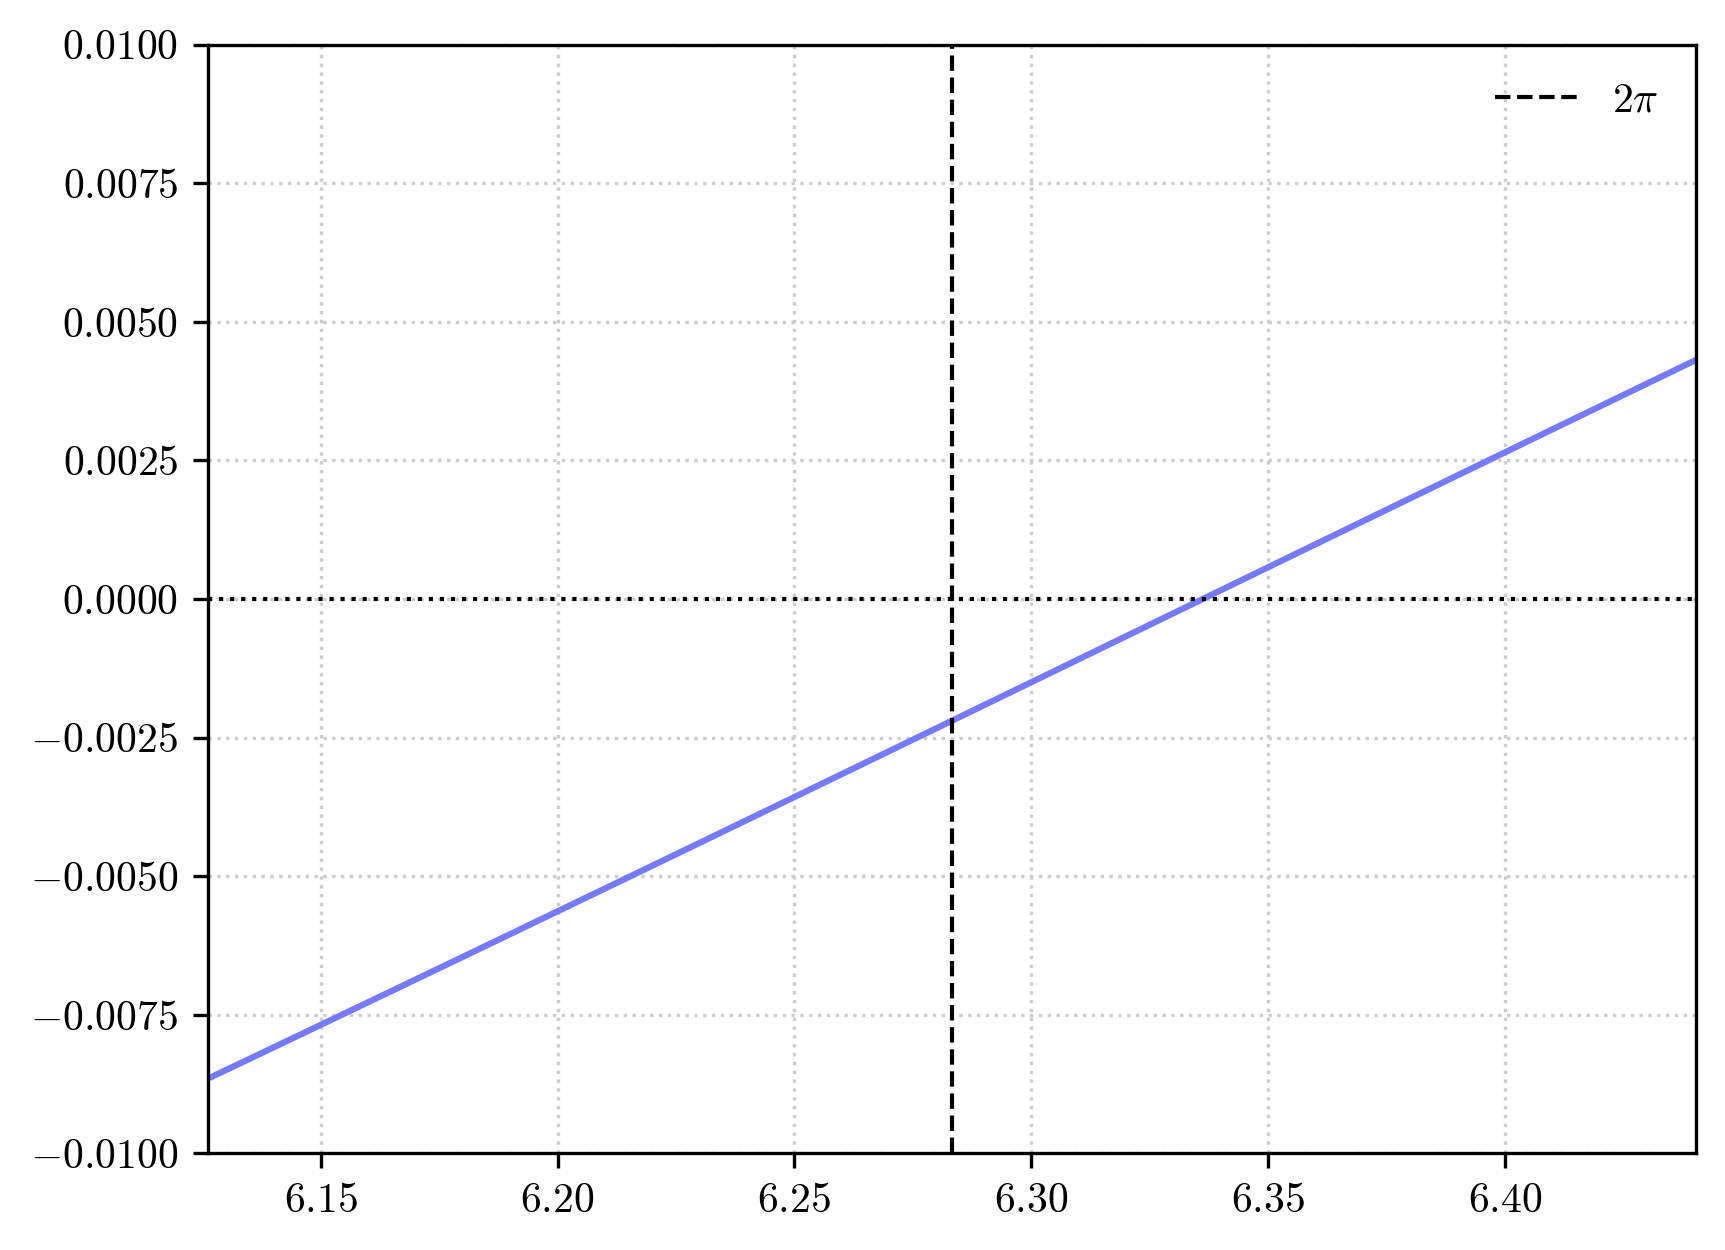

In [11]:
fig, ax = plt.subplots()

ax.plot(orbit.geo.x[:,3], orbit.geo.u[:,1])

ax.set_xlim(2*np.pi-np.pi/20, 2*np.pi+np.pi/20)
ax.set_ylim(-0.01, 0.01)

ax.axhline(0, color = "k", linestyle = ":", linewidth = 1)
ax.axvline(2*np.pi, color = "k", linestyle = "--", linewidth = 1, label = r"$2\pi$")

ax.legend()

plt.show()

we can clearly see that after a complete azimuthal turn the orbit is not yet back at pericenter, but this happens after some additional angle $\Delta\phi$. This angle is what we call the rate of orbital precession per orbital period.

We can easily estimate it by considering the following piece of code:

In [12]:
precession = fsolve(interp1d(orbit.geo.x[:,3], orbit.geo.u[:,1], kind = "cubic"), x0 = 2*np.pi)[0] - 2*np.pi

print(f"Orbital precession = {precession:.5} rad/orbital period")

Orbital precession = 0.053048 rad/orbital period


We have first made use of the ``scipy.interpolate.interp1d`` function to create a cubic interpolant of the $\dot{r}(\phi)$ function. Then we have looked for a root of this funciton (namely, a radial turning point) around $\phi=2\pi$ and than we have computed the difference from $2\pi$ of this angle. This is thus an estimation of how much the orbit precessed over one orbital period.

We can visualize the result:

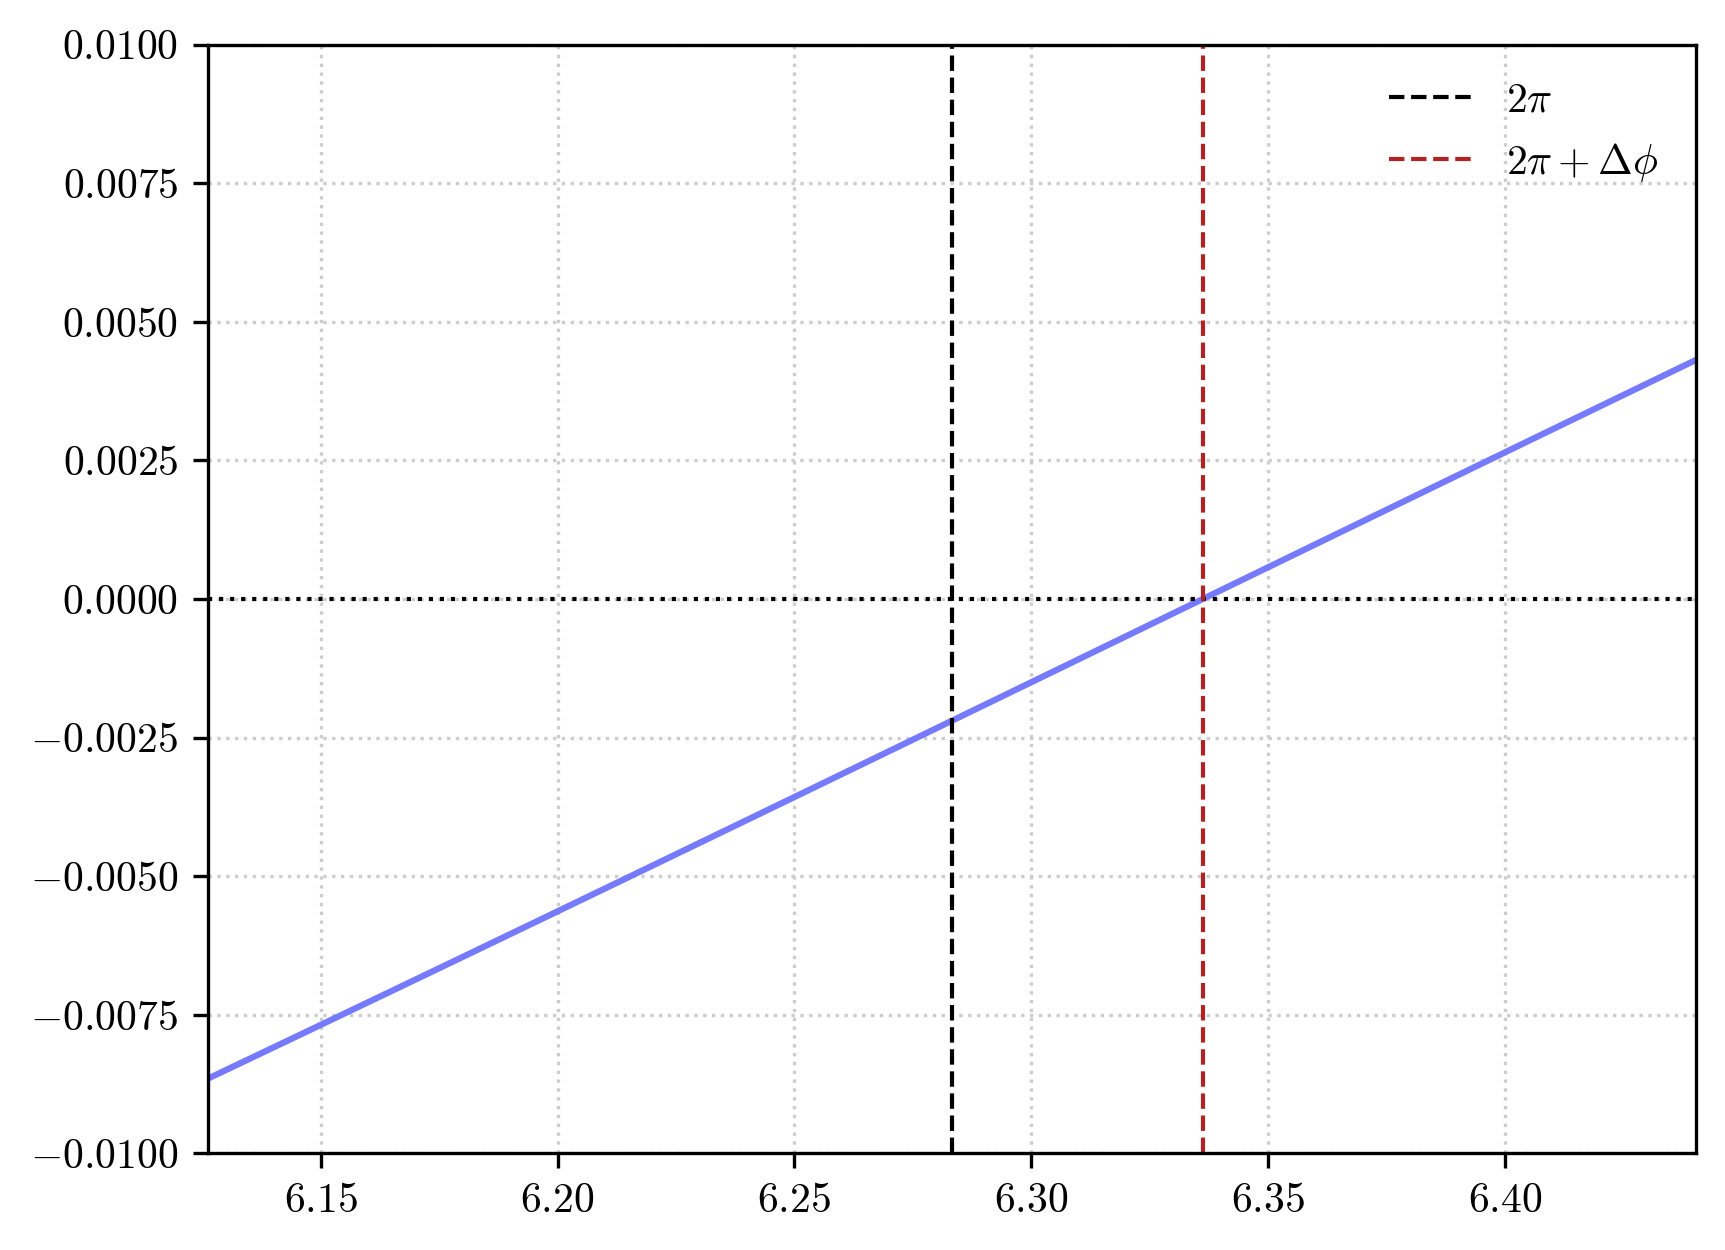

In [13]:
fig, ax = plt.subplots()

ax.plot(orbit.geo.x[:,3], orbit.geo.u[:,1])

ax.set_xlim(2*np.pi-np.pi/20, 2*np.pi+np.pi/20)
ax.set_ylim(-0.01, 0.01)

ax.axhline(0, color = "k", linestyle = ":", linewidth = 1)
ax.axvline(2*np.pi, color = "k", linestyle = "--", linewidth = 1, label = r"$2\pi$")
ax.axvline(precession+2*np.pi, color = "firebrick", linestyle = "--", linewidth = 1, label = r"$2\pi + \Delta\phi$")

ax.legend()

plt.show()

It is now instructive to compare the rate of orbital precession that we have obtained numerically in PyGRO, with the classical post-Newtonian formula of General Relativity

$$
\Delta\phi = \frac{6\pi GM}{a c^2 (1-e^2)}
$$

Since we are considering $G=c=M=1$, we can easily compute it by:

In [14]:
PN_precession = 6*np.pi/(orbit.a*(1-orbit.e**2))

print(f"Post-newtonian orbital precession = {PN_precession:.5} rad/orbital period")

Post-newtonian orbital precession = 0.05236 rad/orbital period


The result obtained from our numerical integration matches with good precision the one obtained with the first order post-newtonian formula.

The (small) discrepancy that we have obtained is not an aritfact of the numerical approach we used. This is a clear manifestation of the fact that the post-Newtonian formula is derived in a weak-field approximation and we are considering a quite-strong field regime of an orbit with a very high eccentricity and only 1000 gravitational radii of semi-major axis.

In order to demonstrate this more quantitatively, let's consider an interval of semi-major axes $a\in[50, 10000]M$ and track the discrepancy between our numerically computed rate of orbital precession and the post-Newtonian formula:

In [15]:
a_arr = np.geomspace(50, 10000, 100)

GR_precession_arr = []
PN_precession_arr = []

for i, a in enumerate(a_arr):
    print(f"Orbit {i+1}/{len(a_arr)}", end = "\r")

    orbit = pygro.Orbit(geo_engine, verbose=False)
    orbit.set_orbital_parameters(0, a, 0.8, 0, 0, 0)

    T = np.sqrt(4*np.pi**2*orbit.a**3)

    orbit.integrate(T*5, 0.1, accuracy_goal = 15, precision_goal = 15, verbose=False)
    
    GR_precession = fsolve(interp1d(orbit.geo.x[:,3], orbit.geo.u[:,1], kind = "cubic"), x0 = 2*np.pi)[0] - 2*np.pi
    PN_precession = 6*np.pi/(orbit.a*(1-orbit.e**2))
    
    GR_precession_arr.append(GR_precession)
    PN_precession_arr.append(PN_precession)

If we now plot the two estimations

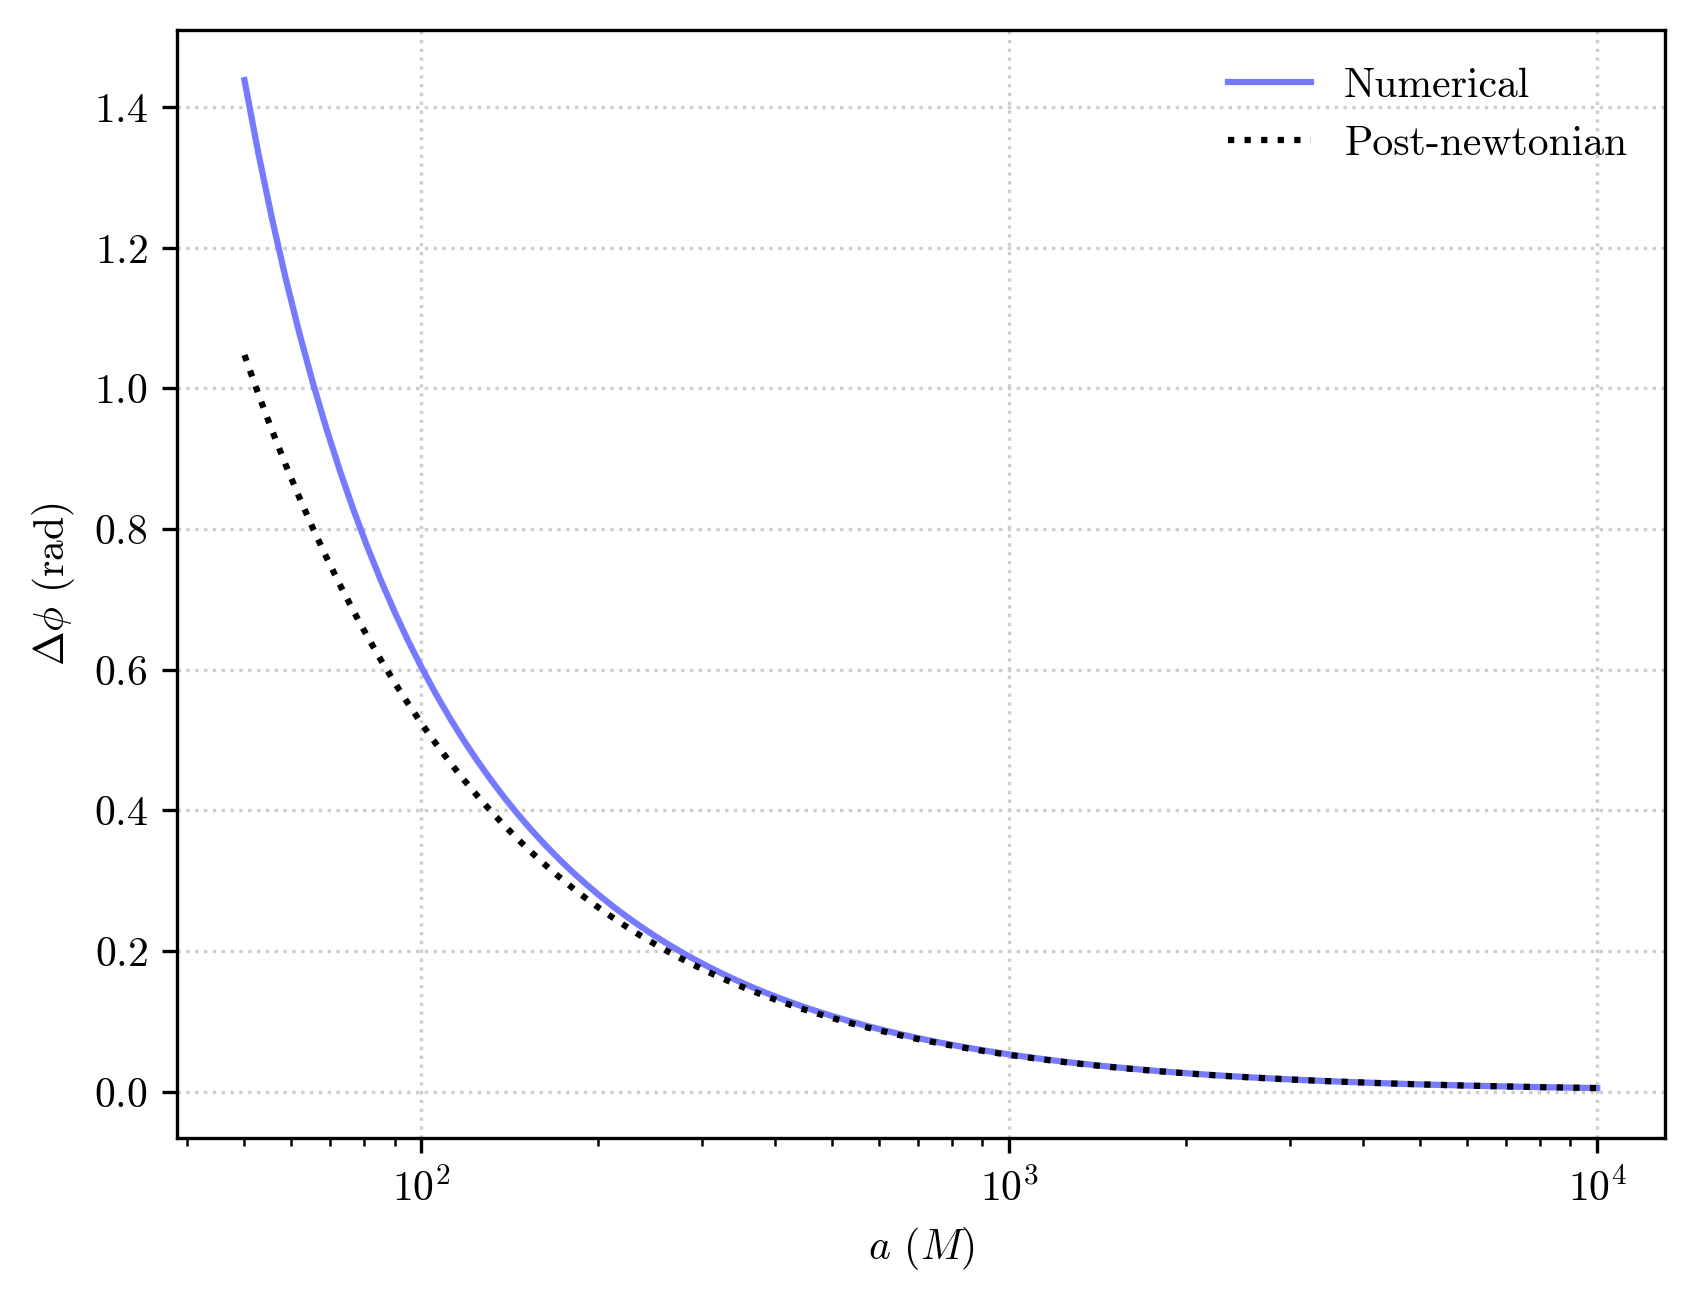

In [16]:
fig, ax = plt.subplots()

ax.plot(a_arr, GR_precession_arr, label = "Numerical")
ax.plot(a_arr, PN_precession_arr, label = "Post-newtonian", linestyle = ":", color = "k")

ax.set_xscale('log')

ax.set_xlabel("$a$ ($M$)")
ax.set_ylabel("$\Delta\phi$ (rad)")

ax.legend()

plt.show()

we can clearly see how the numerically -omputed rate or precession and the post-Newtonian formula converge to the same results for larger values of $a$ or, in other words, in a weak-field gravitational regime.

When $a$ is small, however, the two estiamtions deviate beacuese the first-order post-Newtonian formula fails to capture the full orbital dynamics in a stronger gravitational regime